# Task 1 - LULC tile location map

## General instructions

First, update the following cell to have a link to your Homework 4 GitHub repository

**UPDATE THIS LINK** https://github.com/floraham/eds220-hwk-4.git

Add comments for all your code and commit as needed. Err on the side of commenting and commiting too much for now.

## Overview
The goal of this task is to create a simple map showing the location of the LULC tile section we used in the previous discussion section relative to the state of California and Mount Whitney. 

## About the data

In this task you will use two datsets:

**First dataset**

A small section of the GAP/LANDFIRE National Terrestrial Ecosystems data for 2011, from the US Geological Survey (USGS). This is a raster file with a 30 m x 30 m pixel resolution. Each cell in the raster has a number representing the type of land cover.

The data was pre-processed in the Microsoft Planetary Computer to show a small region around Mount Whitney in California.

Further information about the dataset can be accessed via the the dataset’s Digital Object Identifier (DOI) link:

U.S. Geological Survey (USGS) Gap Analysis Project (GAP), 2016, GAP/LANDFIRE National Terrestrial Ecosystems 2011: U.S. Geological Survey data release, https://doi.org/10.5066/F7ZS2TM0.

**Second dataset**

A shapefile of CA Geographic Boundaries. 
This is a subset of the US Census Bureau's 2016 TIGER database, which only has the state boundary.
[https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b](https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b)

## File management
All your data files must be  inside a directory named 'data'  **in your gitignore**. 

## Data access
The .tif file (same as we used in discussion section) is in the Canvas-week7-homework zip file. The California shapefile will be directly accessed via its URL.

## FINAL CODE
You will use the next cell at the end of the task. Leave it blank for now.

In [1]:
### ===== FINAL CODE =====

## Import libraries and functions

In [2]:
# import libraries and functions here
import os
import numpy as np 
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches # for creating legends 
import shapely
import xarray as xr 
import rioxarray as rioxr 
import geopandas as gpd 
from shapely.geometry import Polygon

from rasterio.features import rasterize #for rasterizing polygons 

## Import data
Use the next two cells to:

1. Import the raster file and store it in a variable `lulc` and take a look at it.
2. Import the CA shapefile directly from the URL using `gpd.read_file()` and take a look at it. You can get it by right-clicking on the "Download" button. Store it as a variable named `ca`.

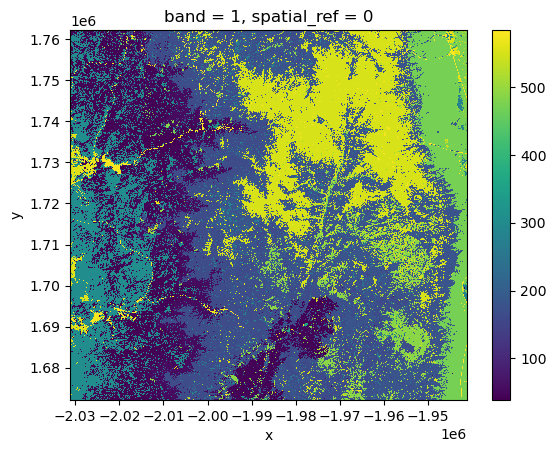

In [3]:
# 1
lulc = rioxr.open_rasterio(os.path.join(os.getcwd(),'data', 'land_cover.tif'))

lulc.plot()

In [4]:
lulc.rio.crs

CRS.from_epsg(5070)

<AxesSubplot:>

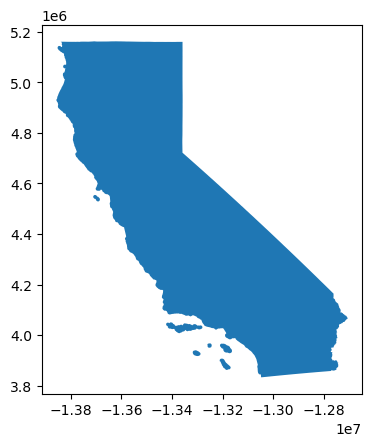

In [5]:
# 2
ca = gpd.read_file('https://data.ca.gov/dataset/e212e397-1277-4df3-8c22-40721b095f33/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b/download/ca-state-boundary.zip')

ca.plot()

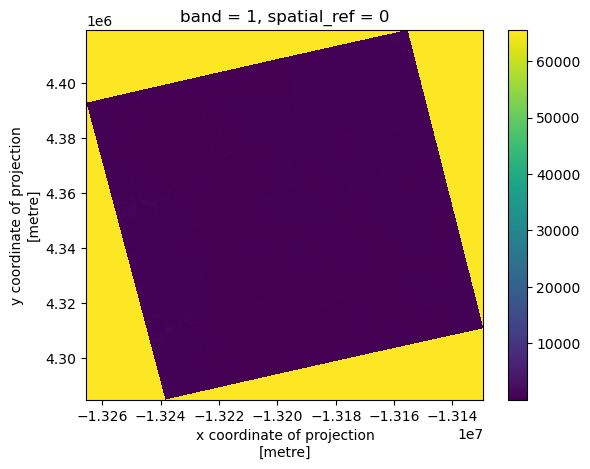

In [6]:
#reprojecting lulc 

lulc = lulc.rio.reproject(ca.crs) 

lulc.rio.crs

lulc.plot()


In [7]:
# showing the original crs using the rio accessor
print(f"Before update:\n lulc crs {lulc.rio.crs} \nbefore update:\n ca crs {ca.crs}")

# the crs don't match, so let's update that before anything else
lulc = lulc.rio.reproject(ca.crs)

# after update:
print(f"After update:\n lulc crs {lulc.rio.crs} \nAfter update:\n ca crs {ca.crs}")

Before update:
 lulc crs EPSG:3857 
before update:
 ca crs epsg:3857
After update:
 lulc crs EPSG:3857 
After update:
 ca crs epsg:3857


min: 39, max: 65,535
no-data value 65535


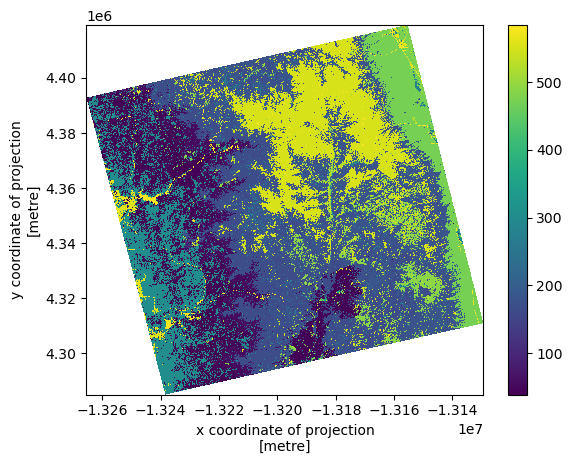

In [22]:
# check min and max
print(f"min: {lulc.min().item():,}, max: {lulc.max().item():,}")

# get no-data value
nodata = lulc.rio.nodata
print('no-data value', nodata)

# select pixels with data using `where()`
lulc.where(lulc != nodata)


# check graph with nodata as nans
lulc = lulc.where(lulc != nodata)

lulc.plot()



## Bounding box
Create a `geopands.GeoDataFrame` named `bbox` with the lulc bounding box. 

In [9]:
# your code here

# Get the bounding box
min_x, min_y, max_x, max_y = lulc.rio.bounds()

points = [[min_x, min_y],
          [max_x, min_y],
          [max_x, max_y],
          [min_x, max_y],
          [min_x, min_y]]

#create geodataframe with aoi 
bbox = gpd.GeoDataFrame(geometry=[Polygon(points)], crs = lulc.rio.crs)


In [10]:
## create raster mask based on alitak polygon
#alitak_mask = rasterize(shapes = [districts.loc[1,'geometry']],  # a list of geometries
#                        out_shape = kodiak_dist.shape,           # shape of outout np array (shape of raster)
#                        transform = kodiak_dist.rio.transform(), # transformation of raster
#                        all_touched = True)  # all pixels touched by geometries will be burned in 
#print(type(alitak_mask))
#alitak_mask

## Mount Whitney point
Create a `geopands.GeoDataFrame` named `mt_whitney` having the coordinates of Mount Whitney as a single point. You will need to look up Mount Whitney's coordinates. HINT: [`shapely.Point()`](https://shapely.readthedocs.io/en/stable/reference/shapely.Point.html)

In [19]:
# Mount Whitney coordinates (latitude, longitude)
coordinates = (-13168238.600765156, 4380516.844251228)

# Create a GeoDataFrame with a single point representing Mount Whitney
mt_whitney = gpd.GeoDataFrame(geometry=[shapely.Point(coordinates)], crs = lulc.rio.crs)


# Print the GeoDataFrame
mt_whitney


,geometry
0,POINT (-13168238.601 4380516.844)


## Updates
If there are any updates needed to the data, perform them in the next cells (you may add as many as you need). 
At the top of each one, include a comment explaining what is happening in that cell's code.

In [12]:
# your code here

##lowercase column names 
ca.columns = ca.columns.str.lower()

#clean up "Year_" to be just "year" 
ca.rename(columns={'year_': 'year'}, inplace=True)

#check data types. It looks like 1) object id needs to be "str"
ca.dtypes

### lulc cleaning
# remove length 1 dimension (band)
lulc = lulc.squeeze()


# remove coordinates associated to band
lulc = lulc.drop('band')
lulc = lulc.drop('spatial_ref')

## Map

Create a map showing `bbox`, `ca` and `mt_whitney` similar to the one in the overview section. 
It must have at least the customizations shown in the sample map. 

HINTS:
1. to change the `marker_style`: https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html
2. to add the marker to the legend: https://matplotlib.org/stable/users/explain/axes/legend_guide.html and update parameter `linestyle='None'` in `mlines.Line2D`

In [13]:
mt_whitney.crs == ca.crs

True

In [14]:
ca.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
bbox.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
ca

,region,division,statefp,statens,geoid,stusps,name,lsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,"MULTIPOLYGON (((-13317677.375 3930590.808, -13..."


In [17]:
bbox

,geometry
0,"POLYGON ((-13265451.192 4285064.365, -13129428..."


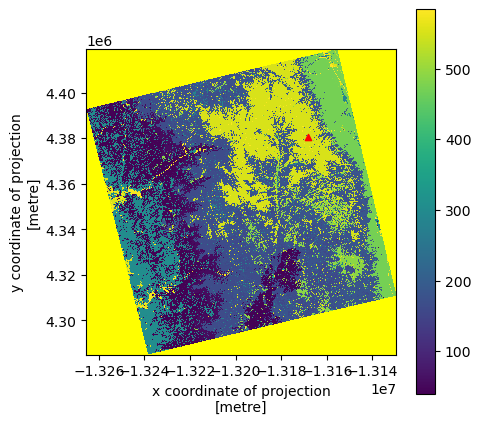

In [30]:
# your code here

fig, ax = plt.subplots(figsize = (5,5))

#lulc.plot(ax=ax) 
ca.plot(ax=ax, color = 'yellow') 
lulc.plot(ax=ax)
#bbox.plot(ax=ax, color = 'blue')

mt_whitney.plot(ax=ax, color='red', markersize=20, marker="^")

plt.show()

## Final code
Collect all the relevant code into the first blank cell of the notebook titled "FINAL CODE". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The only ouput of this cell should be the graph you produced in the previous exercise. 

Add divisions for relevant sections and comment appropriately.
